# Add existing items in a collection

## What is this notebook about?

This notebook allows the upload of an existing local collection into the app.


In [28]:
%pip install -q impresso --upgrade

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.68.1 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.8 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


## Open a working client connection to the Impresso API

Requires a valid API key and secret. You can obtain these from the Impresso website.


In [1]:
from impresso import connect

client = connect()

🎉 You are now connected to the Impresso API!  🎉
🔗 Using API: https://impresso-project.ch/public-api


In [2]:
import pandas as pd

csv_path = "samples/2025-09-18T12-09-21-f40f40f5.csv"

# Skip the disclaimer rows
df = pd.read_csv(csv_path, sep=';', skiprows=4)

print("Columns:", df.columns.tolist())
print("Shape:", df.shape)

# Peek at first few rows
df.head()


Columns: ['uid', 'access_right', 'collections', 'countryCode', 'dataProviderCode', 'excerpt', 'isOnFrontPage', 'is_content_available', 'is_olr', 'issue', 'languageCode', 'locations_mentioned', 'mediaCode', 'mediaPoliticalOrientation', 'mediaTopics', 'newsagencies_mentioned', 'pages', 'periodicity', 'persons_mentioned', 'provinceCode', 'publicationDate', 'relevance', 'title', 'topics', 'totalPages', 'transcript', 'transcriptLength', 'type', 'year']
Shape: (26, 29)


,uid,access_right,collections,countryCode,dataProviderCode,excerpt,isOnFrontPage,is_content_available,is_olr,issue,...,provinceCode,publicationDate,relevance,title,topics,totalPages,transcript,transcriptLength,type,year
0,DTT-1958-07-19-a-i0041,NaN,NaN,CH,Migros,[Copyright restricted],False,N,True,DTT-1958-07-19-a,...,na,1958-07-19T00:00:00Z,4.102252,Jazzecke ää ^ um—¦Mm —uaamri+laJzZtäm,tm-de-all-v2.0_tp87_de|0.619 tm-de-all-v2.0_tp...,1,[Copyright restricted],893,ar,1958
1,DTT-1959-06-27-a-i0223,NaN,NaN,CH,Migros,[Copyright restricted],False,N,True,DTT-1959-06-27-a,...,na,1959-06-27T00:00:00Z,1.096451,mwm®fmmm WMMMMEMW*W>M@>@IMMMM,tm-de-all-v2.0_tp62_de|0.389 tm-de-all-v2.0_tp...,1,[Copyright restricted],3826,ar,1959
2,DTT-1959-07-02-a-i0035,NaN,NaN,CH,Migros,[Copyright restricted],False,N,True,DTT-1959-07-02-a,...,na,1959-07-02T00:00:00Z,4.767456,"Radio Beromünster Mittwoch, 1. Juli 1959...",tm-de-all-v2.0_tp62_de|0.307 tm-de-all-v2.0_tp...,1,[Copyright restricted],536,ar,1959
3,DTT-1970-01-03-a-i0046,NaN,NaN,CH,Migros,[Copyright restricted],False,N,True,DTT-1970-01-03-a,...,na,1970-01-03T00:00:00Z,8.846883,Boro Drascovic: «Horoscope»,tm-de-all-v2.0_tp46_de|0.435 tm-de-all-v2.0_tp...,1,[Copyright restricted],613,ar,1970
4,DTT-1970-01-03-a-i0047,NaN,NaN,CH,Migros,[Copyright restricted],False,N,True,DTT-1970-01-03-a,...,na,1970-01-03T00:00:00Z,4.994109,* -. i.._J,tm-de-all-v2.0_tp87_de|0.407 tm-de-all-v2.0_tp...,1,[Copyright restricted],1419,ar,1970


In [3]:
# --- Extract document IDs ---
if "uid" not in df.columns:
    raise ValueError("Expected 'uid' column with document IDs not found.")

doc_ids = df["uid"].dropna().astype(str).tolist()
print(f"Extracted {len(doc_ids)} doc_ids, example: {doc_ids[:5]}")

Extracted 26 doc_ids, example: ['DTT-1958-07-19-a-i0041', 'DTT-1959-06-27-a-i0223', 'DTT-1959-07-02-a-i0035', 'DTT-1970-01-03-a-i0046', 'DTT-1970-01-03-a-i0047']


In [5]:
import logging
import os


def setup_logging(log_filename: str = "sampling_log.txt"):
    """
    Set up logging to a user-specified file.

    Args:
        log_filename (str): Path to the log file. Defaults to "sampling_log.txt".
    """
    logger = logging.getLogger(__name__)
    logger.setLevel(logging.INFO)

    # Clear existing handlers
    logger.handlers.clear()

    # Create formatter
    formatter = logging.Formatter("%(asctime)s - %(levelname)s - %(message)s")

    # Create file handler
    file_handler = logging.FileHandler(log_filename, mode="w", encoding="utf-8")

    file_handler.setLevel(logging.DEBUG)
    file_handler.setFormatter(formatter)

    # Create console handler
    console_handler = logging.StreamHandler()
    console_handler.setLevel(logging.INFO)
    console_handler.setFormatter(formatter)

    # Add handlers to logger
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)

    # Prevent duplicate logs
    logger.propagate = False

    # Get absolute path of the log file
    absolute_log_path = os.path.abspath(log_filename)
    print(f"Logging configured. Logs will be saved to: {absolute_log_path}")
    return logger


# Set up default logging
logger = setup_logging()

Logging configured. Logs will be saved to: /Users/eboros/projects/4_impresso/impresso-datalab-notebooks/explore-vis/sampling_log.txt


## Functions to create and populate an Impresso user collection

We will define functions to create a new Impresso user collection and add sampled articles to it.
If the collection already exists, we will skip the creation step and proceed to add
articles.


In [6]:
import requests


def create_collection(client, name: str, description: str = "") -> dict:
    """
    Create a new collection in the Impresso public API using a client with a stored bearer token.

    Args:
        client: An authenticated Impresso API client with a `_api_bearer_token` attribute.
        name (str): Name of the collection.
        description (str): Optional description of the collection.

    Returns:
        dict: JSON response from the API.

    Raises:
        ValueError: If the client does not have a valid _api_bearer_token.
        RuntimeError: If the API request fails.
    """
    token = getattr(client, "_api_bearer_token", None)
    if not token:
        raise ValueError("Client does not have a valid _api_bearer_token.")

    url = "https://impresso-project.ch/public-api/v1/collections"
    headers = {
        "Authorization": f"Bearer {token}",
        "Content-Type": "application/json",
        "Accept": "application/json",
    }
    payload = {"name": name, "description": description, "accessLevel": "private"}

    response = requests.post(url, headers=headers, json=payload)

    if response.ok:
        logging.info(f"Collection '{name}' created successfully.")
        logging.debug(f"Response: {response.json()}")
        return response.json()
    else:
        raise RuntimeError(
            f"Failed to create collection: {response.status_code} {response.text}"
        )


In [7]:


def add_docids(
    client: connect,
    collection_id: str,
    doc_ids: list[str],
    delay: float = 30,
) -> None:
    """
    Add article IDs to a collection in batches of 200.

    Args:
        client (connect): Impresso API client.
        collection_id (str): ID of the user collection.
        doc_ids (list[str]): List of article IDs to add.
        delay (float): Delay in seconds between batch uploads. Defaults to 2.

    Returns:
        None
    """
    logger = logging.getLogger(__name__)
    
    logger.debug(f"collection_id: {collection_id}")
    collection = client.collections.get(collection_id)

    logger.info(
        f"Starting to add {len(doc_ids)} documents to collection '{collection_id}'"
    )
    logger.debug(f"Collection details: {collection}")

    batch_size = 200
    for i in range(0, len(doc_ids), batch_size):
        batch = doc_ids[i : i + batch_size]
        logger.debug(
            f"Processing batch {i//batch_size + 1}: documents {i+1} to"
            f" {min(i+batch_size, len(doc_ids))}"
        )

        try:
            client.collections.add_items(collection_id, batch)
            logger.info(
                f"Successfully added {len(batch)} documents to collection"
                f" '{collection_id}'"
            )
        except Exception as e:
            logger.error(f"Error adding batch to collection: {e}")
            raise

        if i + batch_size < len(doc_ids):  # Sleep only if there are more batches
            logger.info(f"Sleeping for {delay} seconds before adding the next batch...")
            time.sleep(delay)

    logger.info(
        f"Completed adding all {len(doc_ids)} documents to collection '{collection_id}'"
    )



In [8]:

def create_collection_with_docs(
    client,
    name: str,
    doc_ids: list[str],
    description: str = "",
    delay: float = 4,
) -> str:
    """
    Create a new collection and populate it with document IDs.

    Args:
        client (connect): Impresso API client.
        name (str): Name of the new collection.
        doc_ids (list[str]): List of document IDs to add to the collection.
        description (str): Optional description of the collection.
        delay (float): Delay in seconds between batch uploads. Defaults to 2.

    Returns:
        str: The ID of the created collection.

    Raises:
        ValueError: If the collection ID is not found in the response.
        Exception: If collection creation or document addition fails.
    """
    logger = logging.getLogger(__name__)
    try:
        logger.info(
            f"Starting to create collection '{name}' with {len(doc_ids)} documents"
        )
        logger.debug(f"Collection description: {description}")

        collection = create_collection(client, name, description or "")
        collection_id = collection.get("uid")
        if not collection_id:
            raise ValueError("Collection ID not found in the response.")

        logger.info(f"Collection '{name}' created with ID: {collection_id}")
        logger.debug(f"Collection response: {collection}")

        time.sleep(delay)
        add_docids(client, collection_id, doc_ids, delay)
        logger.info(
            f"Successfully added {len(doc_ids)} documents to collection '{name}'"
        )

        return collection_id
    except Exception as e:
        logger.error(f"Failed to create collection with docs: {e}")
        raise

2025-09-18 15:13:20,631 - INFO - Starting to create collection 'My Awesome Collection5' with 26 documents
2025-09-18 15:13:20,905 - INFO - Collection 'My Awesome Collection5' created with ID: local-PKxdR5Es-LXSvdnGO
ERROR:root:Received error response (404): <!DOCTYPE html>
<html>
  <head>
    <meta http-equiv="Content-type" content="text/html; charset=utf-8">
    <meta http-equiv="Content-Security-Policy" content="default-src 'none'; style-src 'unsafe-inline'; img-src data:; connect-src 'self'">
    <title>Page not found &middot; GitHub Pages</title>
    <style type="text/css" media="screen">
      body {
        background-color: #f1f1f1;
        margin: 0;
        font-family: "Helvetica Neue", Helvetica, Arial, sans-serif;
      }

      .container { margin: 50px auto 40px auto; width: 600px; text-align: center; }

      a { color: #4183c4; text-decoration: none; }
      a:hover { text-decoration: underline; }

      h1 { width: 800px; position:relative; left: -100px; letter-spacing
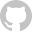
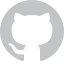

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [10]:
import time

# --- Create a new collection and upload your CSV doc_ids ---
collection_name = "My Awesome Collection5"
collection_description = "My Awesome Collection uploaded from CSV on 2025-09-18"

collection_id = create_collection_with_docs(
    client,
    name=collection_name,
    doc_ids=doc_ids,
    description=collection_description,
    delay=4,  # wait 4s between batches
)

print("✅ Collection created with ID:", collection_id)

In [24]:
collection_description

'My Awesome Collection uploaded from CSV on 2025-09-18'

In [25]:
doc_ids

['DTT-1958-07-19-a-i0041',
 'DTT-1959-06-27-a-i0223',
 'DTT-1959-07-02-a-i0035',
 'DTT-1970-01-03-a-i0046',
 'DTT-1970-01-03-a-i0047',
 'DTT-1970-01-10-a-i0131',
 'DTT-1970-01-10-a-i0132',
 'DTT-1970-01-10-a-i0215',
 'DTT-1970-01-24-a-i0149',
 'DTT-1970-01-31-a-i0062',
 'DTT-1970-02-07-a-i0128',
 'DTT-1971-09-08-a-i0016',
 'NZZ-1858-06-02-a-i0004',
 'NZZ-1860-11-14-a-i0004',
 'NZZ-1863-05-15-a-i0001',
 'NZZ-1867-09-16-a-i0001',
 'NZZ-1881-07-30-a-i0001',
 'NZZ-1886-04-22-a-i0003',
 'luxwort-1850-01-27-a-i0028',
 'luxwort-1850-01-30-a-i0028',
 'luxwort-1862-03-30-a-i0021',
 'luxwort-1872-01-19-a-i0044',
 'luxwort-1883-08-28-a-i0014',
 'luxwort-1889-03-22-a-i0023',
 'luxwort-1892-04-23-a-i0003',
 'luxwort-1947-10-25-a-i0177']